# Assignment 1
## Part A - Titanic

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")

#### Exploratory data analysis

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
for column in train.select_dtypes(exclude=[np.number]).columns.tolist():
    print("{}: {} unique values".format(column, train[column].nunique()))  

Name: 891 unique values
Sex: 2 unique values
Ticket: 681 unique values
Cabin: 147 unique values
Embarked: 3 unique values


In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



- 'Ticket' and 'PassengerId' are unique identifiers and will be excluded from the analysis
- How much a person paid for his/her fare would not directly impact his chances of survival at the time of the incident. Fare could be associated with factors such as class, cabin location, which could reasonably be expected survival but thesse factors are available in the training set. Therefore, 'Fare' will be excluded from analysis. 
- Data types for categorical variables such as 'Survived' and 'Pclass' will be converted from numerical to 'str'
- There are missing values for 'Age' and 'Embarked'. These will need to be filled in later


In [7]:
for column in ['Survived', 'Pclass']:
    train[column] = train[column].astype('str')

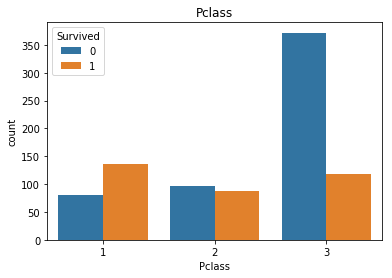

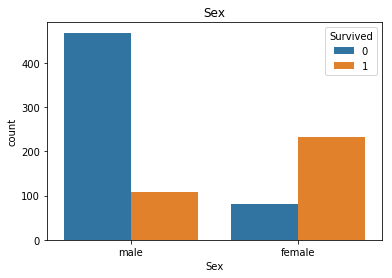

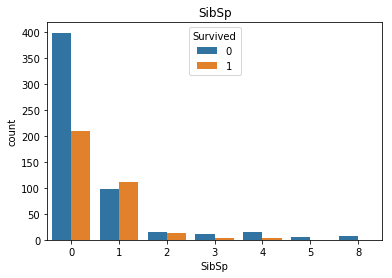

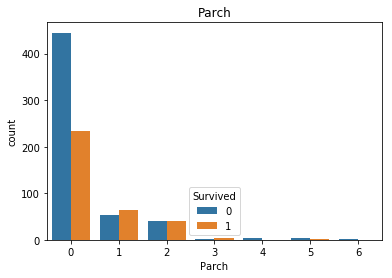

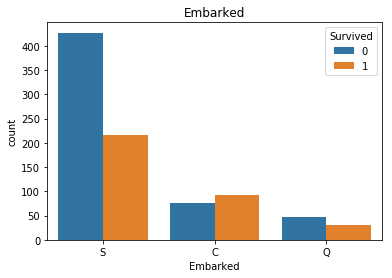

In [8]:
cols = ['Pclass', 'Sex', 'SibSp','Parch', 'Embarked']
for col in cols:
    plt.figure()
    sns.countplot(x=col, data = train, hue="Survived")
    plt.title(col)

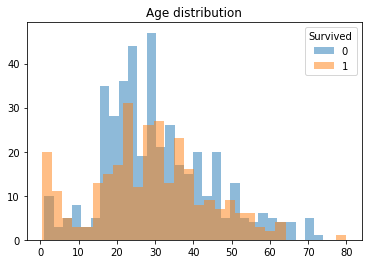

In [9]:
for status in train["Survived"].unique():
    plt.hist(x='Age',data=train[(train['Survived']==status) & (~train['Age'].isna())], alpha=0.5, label=status, bins=30)
    plt.title("Age distribution")
    plt.legend(title="Survived")

- Females and better Pclass (1 and 2) tend to have higher proportions of survivors
- Those not travelling with family (SibSp or Parch = 0) and those embarking at 'S' tend to have lower proportions of survivors

- Age appears to impact on the likelihood of survival, with a much higher proportion of survivors at the age ranges of 0-5 compared to other age groups

#### Data cleaning/wrangling
##### SibSp/Parch
From the prelim data analysis, passengers travelling without SibSp/Parch tend to have lower survival rates. A new column will be created to indicate whether passenger has any family(SipSp or Parch) on board. 

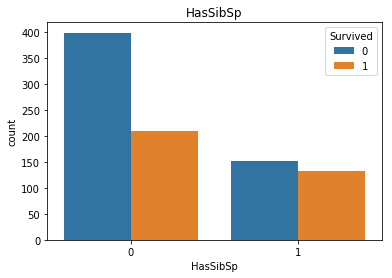

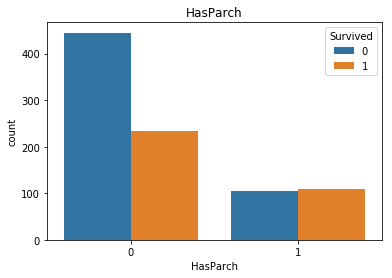

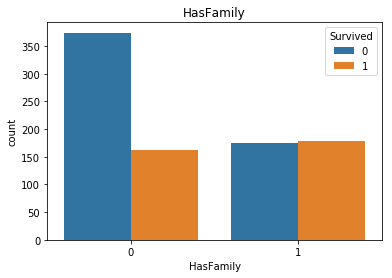

In [10]:
def transform_family_info(df):
    df["HasSibSp"] = 1
    df["HasParch"] = 1
    df["HasFamily"] = 1
    df.loc[df["SibSp"]==0,"HasSibSp"]=0
    df.loc[df["Parch"]==0,"HasParch"]=0
    df.loc[(df["HasSibSp"]==0)&(df["HasParch"]==0), "HasFamily"]=0
    
    return df


train = transform_family_info(train)

for col in ["HasSibSp","HasParch","HasFamily"]:
    plt.figure()
    sns.countplot(x=col, data = train, hue="Survived")
    plt.title(col)

There is a marked difference in survival rates for passengers with no family on board.'HasFamily' will be retained while 'HasSibSp' and 'HasParch' will be dropped as "Parch", "SibSp" and "HasFamily" would provide the same information.

##### Age
From the prelim data analysis, age appears to impact survival likelihood. 

The 'Name' column contains titles i.e. Mr, Mrs etc. This info may be useful for a differentiated approach in filling missing 'Age' values. For example, "Master" was a form of address for younger males in the early 20th century. We would also expect titles such as "Dr", "Col" and "Sir" to refer to more mature passengers.

'Title' will be extracted from the "Name" column and missing 'Age' values will be filled based on the median of that corresponding title.  This would avoid overestimating 'Age' for certain groups such as 'Master', which tend to have lower age values that are in the range where age has a big impact on survival likelihood.

In [11]:
train['title'] = train['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip()) #extract titles from names

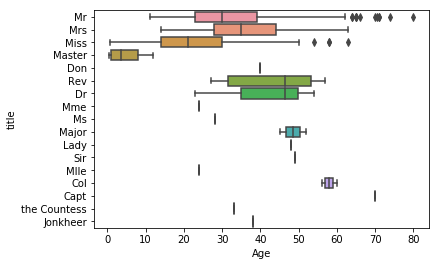

In [12]:
sns.boxplot(x="Age", y="title", data=train)    

The above figure confirms that there is some variation in age distributions for different titles. Missing 'Age' values will therefore be filled using the median age for the corresponding titles.

In [13]:
age_medians  = train.pivot_table(columns="title", aggfunc='median', values="Age") #create table of medians by title

age_medians['overall'] = train['Age'].median() #create an overall median age value. this helps to address missing values in test data which has no or new values for 'title'

def fill_age(df): #filling age NAs based with median age based on title, else with overall median age if no such title exists in age_medians
    title = df['title'].unique().item()
    try:
        df['Age'].fillna(age_medians.loc['Age',title], inplace=True)
    except:
        df['Age'].fillna(age_medians.loc['Age','overall'], inplace=True)
    return df

train = train.groupby('title').apply(lambda x: fill_age(x))

##### Cabin

According to [this wikipedia article](https://en.wikipedia.org/wiki/Sinking_of_the_RMS_Titanic#%22Iceberg_right_ahead!%22_(23:39)), the collision happened close to midnight, so most passengers had gone to bed. "Cabin" would be a good indication of where each passenger was at the time of collision, which would affect their chances of survival (i.e. access to life boats etc). 

'Cabin_Deck' and "Cabin_Number" can be extracted from "Cabin". Furthermore, according to [Titanic deckplans](https://www.encyclopedia-titanica.org/titanic-deckplans/), even-numbered cabins are located on one side of the ship and odd-numbered ones on the other. A 'Cabin_Number_Loc' column will be created to reflect this.



In [14]:
def get_cabin_info(df):
    
    #extract Cabin Deck and Number
    df['Cabin_Deck']= np.NaN
    df['Cabin_Number']= np.NaN
    df['Cabin_Number_Loc']= np.NaN
    df.loc[~df['Cabin'].isna(),'Cabin_Deck']  = df.loc[~df['Cabin'].isna(),'Cabin'].apply(lambda x:x[0]) #extract alphabet
    df.loc[~df['Cabin'].isna(), 'Cabin_Number']  = df.loc[~df['Cabin'].isna(), 'Cabin'].apply(lambda x:x[1:].split(' ')[0]) #retain only first booth number if entries have multiple booths
    df['Cabin_Number'] =  pd.to_numeric(df['Cabin_Number'], errors='coerce')
    df.loc[df['Cabin_Number']%2==0, 'Cabin_Number_Loc']="even"
    df.loc[df['Cabin_Number']%2==1, 'Cabin_Number_Loc']="odd"
    
    return df

train = get_cabin_info(train)

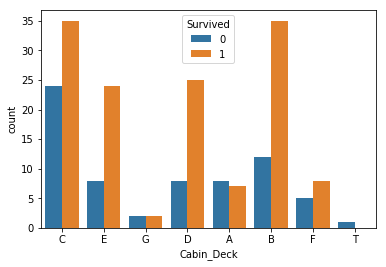

In [15]:
#sns.countplot(x='Cabin_Deck',data=train[~train['Cabin_Deck'].isna()],hue="Survived")
sns.countplot(x='Cabin_Deck',data=train[~train['Cabin_Deck'].isna()],hue="Survived")

In [16]:
train['Cabin_Deck'] = train['Cabin_Deck'].replace("T",np.NaN) #There is no Deck T

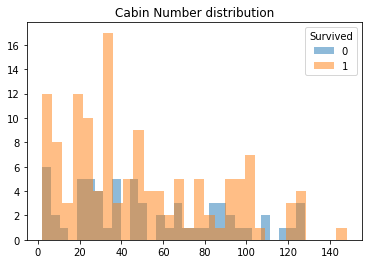

In [17]:
for status in train["Survived"].unique():
    plt.hist(x='Cabin_Number',data=train[(train['Survived']==status) & (~train['Cabin_Number'].isna())], alpha=0.5, label=status, bins=30)
    plt.title("Cabin Number distribution")
    plt.legend(title="Survived")

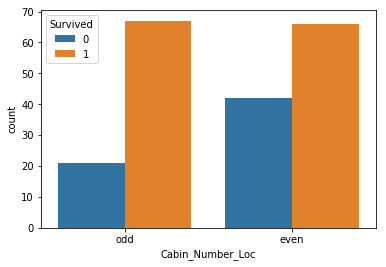

In [18]:
sns.countplot(x='Cabin_Number_Loc',data=train[~train['Cabin_Number_Loc'].isna()],hue="Survived")

In [19]:
train[['Cabin','Cabin_Deck','Cabin_Number','Cabin_Number_Loc']].nunique()

train[['Cabin','Cabin_Deck','Cabin_Number','Cabin_Number_Loc']].isna().sum()

Cabin               687
Cabin_Deck          688
Cabin_Number        695
Cabin_Number_Loc    695
dtype: int64

Cabin location appears to have an impact on survival likelihood. Passengers on G and A Deck appear to be more likely to perish compared to other decks. Passengers with even numbered cabin numbers are also more likely to perish.

Over 75% of 'Cabin_Deck' and 'Cabin_Number_Loc' are missing, so these values will be labelled "U" for unknown. It is noted that creating a pseudo category for missing values may adversely impact the performance of the model as these missing values would necessarily belong to one of the named groups in reality.

Nevertheless, information provided by non-missing 'Cabin_Deck' and 'Cabin_Number_Loc' values may bring benefits that outweigh the potential pitfalls of setting "U" to NA values.

Models will be trained with and without 'Cabin_Deck' and 'Cabin_Number_Loc' and compared to see which gives a higher cross validation score i.e. a more robust and accurate model. 

In [20]:
for col in ['Cabin','Cabin_Deck','Cabin_Number','Cabin_Number_Loc']:
    train[col].fillna("U",inplace=True)

##### Embarked

There were 2 missing values for Embarked, which will be filled with the mode

In [21]:
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode())

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
PassengerId         891 non-null int64
Survived            891 non-null object
Pclass              891 non-null object
Name                891 non-null object
Sex                 891 non-null object
Age                 891 non-null float64
SibSp               891 non-null int64
Parch               891 non-null int64
Ticket              891 non-null object
Fare                891 non-null float64
Cabin               891 non-null object
Embarked            889 non-null object
HasSibSp            891 non-null int64
HasParch            891 non-null int64
HasFamily           891 non-null int64
title               891 non-null object
Cabin_Deck          891 non-null object
Cabin_Number        891 non-null object
Cabin_Number_Loc    891 non-null object
dtypes: float64(2), int64(6), object(11)
memory usage: 132.3+ KB


In [23]:
#Summarizing the data cleaning / preprocessing steps in a single function to facilitate processing of train and test data
def preproc(df):
    
    #fill missing age values
    df['title'] = df['Name'].apply(lambda x:x.split(',')[1].split('.')[0].strip()) #extract titles from names
    df = df.groupby('title').apply(lambda x: fill_age(x))
    
    #transform cabin info
    df = get_cabin_info(df) 
    
    #change Pclass to categorical var
    df['Pclass']=df['Pclass'].astype('str')
    
    #fill missing Embarked data
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode())
    
    #create categorical SibSp/Parch/Family columns
    transform_family_info(df)
    
    return df


#### Model Training



2 algorithms will be considered for model training: random forest, which minimizes overfitting; and logistic regression, which is relatively robust classifier with highly interpretable results.

The labelled data will be split into a training and test set. N-fold cross-validation and GridSearch will be used to train and optimize models using the training set.

Cross validation scores will inform the selection of the final model, whose predictive performance will be evaluated using the held-out labelled test set.

Subsequently, the model will be used to make predictions on the unlabelled data.

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [30]:
#include only variables of interest
variables = ["Pclass","Sex","Age","SibSp","Parch", "Embarked", "HasSibSp", "HasParch", "Cabin_Deck", "Cabin_Number_Loc"]
cat_var = ["Sex","Embarked","Pclass", "Cabin_Deck", "Cabin_Number_Loc"]

X = train[variables]

X = pd.get_dummies(X, columns=cat_var)
y = train["Survived"]
X.info()

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=43)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 24 columns):
Age                      891 non-null float64
SibSp                    891 non-null int64
Parch                    891 non-null int64
HasSibSp                 891 non-null int64
HasParch                 891 non-null int64
Sex_female               891 non-null uint8
Sex_male                 891 non-null uint8
Embarked_C               891 non-null uint8
Embarked_Q               891 non-null uint8
Embarked_S               891 non-null uint8
Pclass_1                 891 non-null uint8
Pclass_2                 891 non-null uint8
Pclass_3                 891 non-null uint8
Cabin_Deck_A             891 non-null uint8
Cabin_Deck_B             891 non-null uint8
Cabin_Deck_C             891 non-null uint8
Cabin_Deck_D             891 non-null uint8
Cabin_Deck_E             891 non-null uint8
Cabin_Deck_F             891 non-null uint8
Cabin_Deck_G             891 non-null uint8
Cabin_Deck_U 

##### Include cabin data
#### Random Forest

In [31]:
def randomforestclassifier(X,y):
    rf = RandomForestClassifier(random_state=77)

    params = {'n_estimators': np.arange(100,500,100), 'min_samples_split':np.arange(2,10,2),'criterion':["gini","entropy"]}

    rf_model_cv = GridSearchCV(rf, params, cv=StratifiedKFold(n_splits = 5, random_state=77), scoring='accuracy')
    rf_model_cv.fit(X,y)
    
    print("Cross validation score:{:.3f}".format(rf_model_cv.best_score_))
    print("Best params:{}".format(rf_model_cv.best_params_))

    return rf_model_cv

rfc1 = randomforestclassifier(X_train,y_train)


Cross validation score:0.814
Best params:{'criterion': 'gini', 'min_samples_split': 8, 'n_estimators': 300}


#### Logistic Regression

In [32]:
def logisticregression(X,y):
    log = LogisticRegression(max_iter=500)

    params = {'C':np.linspace(0.1,1,10), 'solver':['liblinear','lbfgs', 'newton-cg']}

    log_model_cv = GridSearchCV(log, params, cv=StratifiedKFold(n_splits=5,random_state=77), scoring = "accuracy")
    log_model_cv.fit(X,y)

    print("Cross validation score:{:.3f}".format(log_model_cv.best_score_))
    print("Best params:{}".format(log_model_cv.best_params_))
    return log_model_cv
    
log1 = logisticregression(X_train,y_train)

Cross validation score:0.841
Best params:{'C': 0.30000000000000004, 'solver': 'liblinear'}


##### Exclude Cabin Data:

In [33]:
variables2 = ["Pclass","Sex","Age","SibSp","Parch", "Embarked", "HasSibSp", "HasParch"]
cat_var = ["Sex","Embarked","Pclass"]

X2 = train[variables2]

X2 = pd.get_dummies(X2, columns=cat_var)
y2 = train["Survived"]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,test_size=0.3, random_state=43)


In [34]:
rfc2 = randomforestclassifier(X2_train,y2_train)
log2 = logisticregression(X2_train,y2_train)

Cross validation score:0.812
Best params:{'criterion': 'entropy', 'min_samples_split': 8, 'n_estimators': 200}
Cross validation score:0.825
Best params:{'C': 0.2, 'solver': 'liblinear'}


Cross validation scores for all 4 models are comparable and range between 81-84%

For both Log Regression and Random Forest, cross validation scores are higher for models trained using the cabin data.

The Log Regression model trained with cabin data (log1 model) will be selected as the final model to assess performance on the held-out labelled data and to make predictios for unlabelled data. The log regression also has an advantage over random forest in that its outputs are more interpretable (coefficients reflect whether input variables negatively or positively affect outcome) 


#### Model Evaluation

In [35]:
#Get importances/weights of features 
feature_importance_rf = pd.Series(rfc1.best_estimator_.feature_importances_, index = X.columns).sort_values(ascending=False)
weights_log = pd.Series(log1.best_estimator_.coef_.transpose()[:,0], index=X.columns).sort_values(ascending=False)


Text(0.5, 1.0, 'Feature Importances for Random Forest Model')

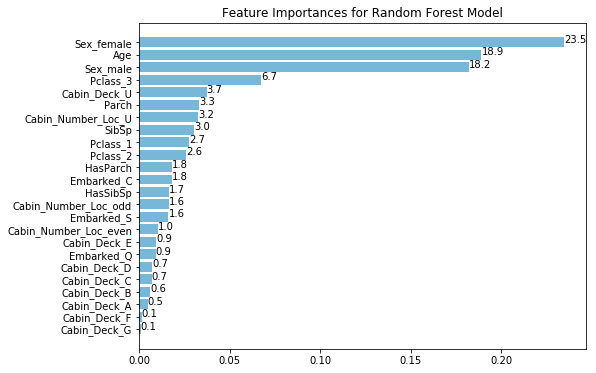

In [36]:
#visualize feature importances for rfc1

fig, ax = plt.subplots(figsize=(8,6))
ypos = np.arange(0,len(feature_importance_rf))[::-1]
ax.barh(ypos,feature_importance_rf.values, color='#77B7D8')

ax.set_yticks(ypos)
ax.set_yticklabels(feature_importance_rf.index)

for i,value in zip(ypos, feature_importance_rf.values):
    ax.annotate("{:.1f}".format(value*100), xy=(value, i))
    
plt.title("Feature Importances for Random Forest Model")

Text(0.5, 1.0, 'Coefficients for Log Regression Model')

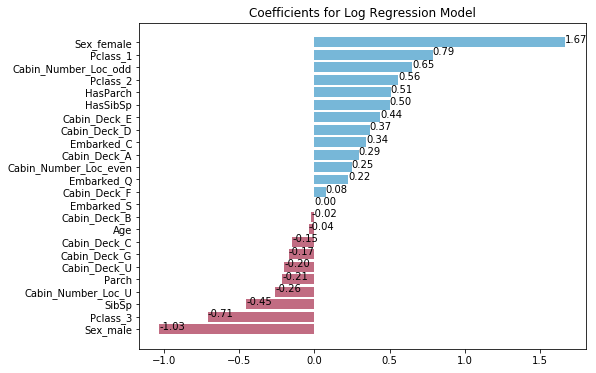

In [37]:
#visualize coefficients for log1
fig, ax = plt.subplots(figsize=(8,6))
ypos = np.arange(0,len(weights_log))[::-1]

positive_weights = weights_log[weights_log>=0]
ypos_positive = ypos[weights_log>=0]
negative_weights = weights_log[weights_log<0]
ypos_negative = ypos[weights_log<=0]
ax.barh(ypos_positive,positive_weights, color='#77B7D8')
ax.barh(ypos_negative,negative_weights, color='#C16C82')

ax.set_yticks(ypos)
ax.set_yticklabels(weights_log.index)

for i,value in zip(ypos, weights_log.values):
    ax.annotate("{:.2f}".format(value), xy=(value, i))
    
plt.title("Coefficients for Log Regression Model")

In [38]:
#evaluate prediction accuracy on held out labelled data set using log1 model
y_pred = log1.predict(X_test)

print("MODEL PERFORMANCE")
print("Accuracy: {:.2f}%".format(accuracy_score(y_test,y_pred)*100))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test,y_pred)))


MODEL PERFORMANCE
Accuracy: 78.36%
Confusion matrix:
[[144  20]
 [ 38  66]]


In [39]:
#evaluate prediction accuracy using a baseline guess of y_test.mode() for all predictions
y_pred2 = np.repeat(y_test.mode(), len(y_test))

print("BASELINE PERFORMANCE")
print("Accuracy: {:.2f}%".format(accuracy_score(y_test,y_pred2)*100))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test,y_pred2)))

BASELINE PERFORMANCE
Accuracy: 61.19%
Confusion matrix:
[[164   0]
 [104   0]]


#### Conclusions

The log model gives an accuracy of 78% on the held out test set, a 17% improvement over the baseline. Being female, in Pclass 1 or 2 or having an odd numbered cabin appears to improve the likelihood of survival.

Being male, Pclass 3 tends to reduce survival likelihood.

Interestingly, "SibSp" has a negative coefficient i.e. a higher number reduces the likelihood of survival. On the other hand, "HasSibSp" has a positive coefficient, survival likelhood is higher for those with siblings/spouses on board than those without. A similar, but less pronounced trend is seen for Parch.

We could infer that having a large number of family members on board might adversely affect survival (having a large family may delay escape as one may try to find all the family members before getting on a life boat), while not having any family on board at all also adversely affects survival (i.e. there is no one to help look out for you)

#### Predictions on unlabelled test set

In [40]:
test = pd.read_csv("test.csv")
test_cleaned = preproc(test) #preprocess test data in the same way as train
test_cleaned  = test_cleaned[variables]
test_cleaned  = pd.get_dummies(test_cleaned , columns=cat_var)


def add_missing_dummy_columns(train, test): #ensure test set has same columns as training set
    missing_cols = set(train.columns) - set(test.columns) 
    for c in missing_cols:
        test[c] = 0
    test = test[train.columns]
    return test

X_test_unlabelled = add_missing_dummy_columns(X,test_cleaned)


In [41]:
filename = "predictions.csv"

predictions = log1.predict(X_test_unlabelled) 
predictions_df = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': predictions})
predictions_df.to_csv(filename, index=False)